In [3]:
# !conda list | grep bitsandbytes

In [2]:
# !conda install -c conda-forge polars pandas scipy seaborn transformers evaluate accelerate sentencepiece -y

In [1]:
from typing import Optional, Union
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import evaluate
import os
from scipy.special import softmax

from pathlib import Path
import wandb
from datasets import Dataset # HuggingFace
from dataclasses import dataclass
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoModel, IntervalStrategy
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

/home/daniel/mambaforge/envs/pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 4090')

In [3]:
import logging
#logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(message)s')

pl.Config(fmt_str_lengths=2000);

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'DeBERTa V3 Osmulski.ipynb'

In [5]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [6]:
# !conda install wandb -y

In [7]:
# !pip install seaborn

In [8]:
deberta_v3_large = 'microsoft/deberta-v3-large'

In [9]:
df_test = pd.read_csv('data/train.csv')
df_test = df_test.drop(columns="id")
df_test.columns

Index(['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'], dtype='object')

In [10]:
options = ['A', 'B', 'C', 'D', 'E']
long_test = pl.DataFrame(df_test).melt(['prompt', 'answer'], options, variable_name='option')
long_test = long_test.with_columns(long_test['value'].str.lengths().alias('answer_length'))
long_test[:4]

prompt,answer,option,value,answer_length
str,str,str,str,u32
"""Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed ""missing baryonic mass"" discrepancy in galaxy clusters?""","""D""","""A""","""MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called ""fuzzy dark matter.""""",164
"""Which of the following is an accurate definition of dynamic scaling in self-similar systems?""","""A""","""A""","""Dynamic scaling refers to the evolution of self-similar systems, where data obtained from snapshots at fixed times exhibits similarity to the respective data taken from snapshots of any earlier or later time. This similarity is tested by a certain time-dependent stochastic variable x.""",285
"""Which of the following statements accurately describes the origin and significance of the triskeles symbol?""","""A""","""A""","""The triskeles symbol was reconstructed as a feminine divine triad by the rulers of Syracuse, and later adopted as an emblem. Its usage may also be related to the Greek name of Sicily, Trinacria, which means ""having three headlands."" The head of Medusa at the center of the Sicilian triskeles represents the three headlands.""",323
"""What is the significance of regularization in terms of renormalization problems in physics?""","""C""","""A""","""Regularizing the mass-energy of an electron with a finite radius can theoretically simplify calculations involving infinities or singularities, thereby providing explanations that would otherwise be impossible to achieve.""",221


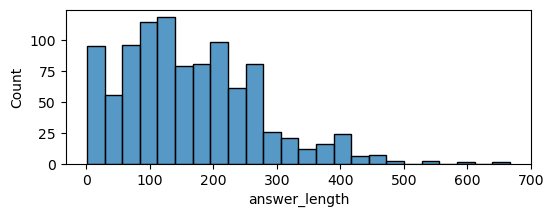

In [11]:
plt.figure(figsize=(6,2))
sns.histplot(long_test, x='answer_length');

In [12]:
df_6000 = pd.read_csv('data/osmulski_15k.csv', dtype=str)
df_train = df_6000[:5800]
df_test_1 = df_6000[5800:]
df_test_2 = pd.read_csv('data/osmulski_extra_train.csv')
print(df_train.shape, df_test_1.shape, df_test_2.shape)

(5800, 7) (9200, 7) (500, 7)


In [13]:
long_train = pl.DataFrame(df_train).melt(['prompt', 'answer'], options, variable_name='option')
long_train = long_train.with_columns(long_train['value'].str.lengths().alias('answer_length'))
long_train[:4]

prompt,answer,option,value,answer_length
str,str,str,str,u32
"""Who was responsible for the reorganisation of New Army reserve units during the First World War?""","""C""","""A""","""Territorial brigades""",20
"""What film earned Rakshit Shetty the Karnataka State Film Award for Director's First Time Best Film?""","""C""","""A""","""Rakshit Shetty did not win the Karnataka State Film Award for Director's First Time Best Film""",93
"""What is the population of Maklavan?""","""E""","""A""","""Maklavan has a population of 5,000 individuals, according to the 2006 census.""",77
"""What was the stud fee for Empire Maker at Gainesway Farm in 2016?""","""D""","""A""","""$90,000""",7


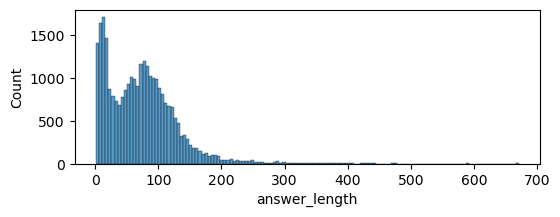

In [14]:
plt.figure(figsize=(6,2))
sns.histplot(long_train, x='answer_length');

In [15]:
option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

def preprocess(example):
    first_sentence = [str(example['prompt'])] * 5
    second_sentences = [str(example[option]) for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, truncation=True)
    tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = 'label' if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [16]:
deberta_v3_large = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large, max_length=200)

train_dataset = Dataset.from_pandas(df_train, preserve_index=False)
tokenized_train = train_dataset.map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_train

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/daniel/mambaforge/envs/pytorch/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/5800 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 5800
})

In [17]:
test_dataset = Dataset.from_pandas(df_test)
tokenized_test = test_dataset.map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})

## Training

In [18]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

In [19]:
def score_random():
    n_permutations = 200
    n_numbers = 5 
    # In this code, np.random.rand(n_permutations, n_numbers) generates a 2D array of random numbers.
    # argsort(axis=1) then sorts along the second dimension (i.e., sorts each row) but instead of 
    # sorting the actual numbers, it sorts their indices, effectively creating a permutation.
    random_predictions = np.random.rand(n_permutations, n_numbers).argsort(axis=1)
    random_actuals = np.random.randint(0, n_numbers-1, n_permutations)
    return mean_avg_precision_at_k(random_predictions, random_actuals)
    
scores = []
for i in range(100000):
    scores.append(score_random())

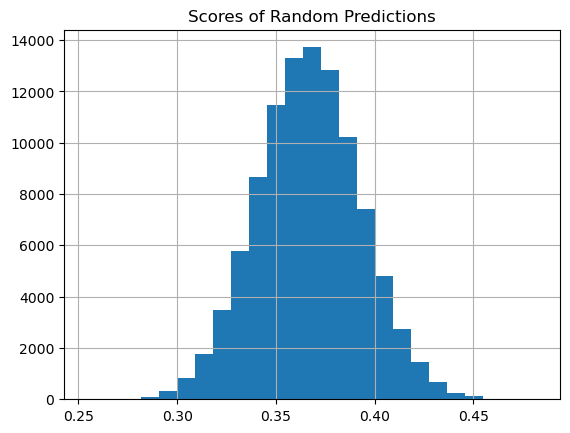

In [20]:
pd.Series(scores).hist(bins=25)
plt.title('Scores of Random Predictions');

In [21]:
acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [22]:
AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [ ]:
retrain = True

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    #warmup_ratio=0.5,
    #learning_rate=5e-6,
    #weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=100,
    eval_steps=200,
    num_train_epochs=3,
    save_steps=5000,
    report_to='wandb',
    output_dir=str(output_path),
    run_name='Train on reduced Osmulski'
)

if not output_path.exists() or retrain:
    model = AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)
    
    embedding_lr = 1e-8
    early_layers_lr = 1e-7
    middle_layers_lr = 1e-6
    late_layers_lr = 2e-5
    classifier_lr = 5e-5

    optimizer_grouped_parameters = [
        {'params': model.deberta.embeddings.parameters(), 'lr': embedding_lr},
        {'params': model.deberta.encoder.layer[:8].parameters(), 'lr': early_layers_lr},
        {'params': model.deberta.encoder.layer[8:16].parameters(), 'lr': middle_layers_lr},
        {'params': model.deberta.encoder.layer[16:].parameters(), 'lr': late_layers_lr},
        {'params': model.classifier.parameters(), 'lr': classifier_lr},
    ]
    optimizer = AdamW(optimizer_grouped_parameters)
    
    num_epochs = 3
    total_steps = len(train_dataset) // training_args.per_device_train_batch_size * num_epochs

    warmup_ratio = 0.5
    warmup_steps = int(total_steps * warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )
    
    trainer.train()
    wandb.finish()
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/'checkpoint-19500')

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: datadan. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


## Predicting on the Testset

In [ ]:
def evaluate_model(test_set):
    tokenized_test_dataset = Dataset.from_pandas(test_set).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E'])
    test_predictions = trainer.predict(tokenized_test_dataset).predictions
    print(compute_metrics([test_predictions, tokenized_test_dataset['label']]))
    
evaluate_model(df_test)
evaluate_model(df_test_1)
evaluate_model(df_test_2)

In [ ]:
trainer_predict = trainer.predict(tokenized_test_dataset)

In [ ]:
trainer_predict.predictions?

In [ ]:
tokenized_test_dataset = Dataset.from_pandas(df_test).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E'])
test_logits = trainer.predict(tokenized_test_dataset).predictions
test_probs = softmax(test_logits, axis=1)
predictions = np.flip(test_logits.argsort(axis=1), axis=1)
pred_1 = predictions[:, 0]
pred_2 = predictions[:, 1]
pred_3 = predictions[:, 2]

row_indcs = np.arange(pred_1.shape[0])
res = pd.DataFrame({
    'pred_1': pred_1, 
    'prob_1': test_probs[row_indcs, pred_1],
    'pred_2': pred_2, 
    'prob_2': test_probs[row_indcs, pred_2],
    'pred_3': pred_3, 
    'prob_3': test_probs[row_indcs, pred_3],
    'logit_sum': test_probs.sum(axis=1),
    'prob_3_sum': test_probs[row_indcs, pred_1] + test_probs[row_indcs, pred_2] + test_probs[row_indcs, pred_3],
    'actual': tokenized_test_dataset['label'],
    'accurate': pred_1 == tokenized_test_dataset['label'],
    'precision_at_3': precision_at_k(predictions, tokenized_test_dataset['label']).round(2)
})

In [ ]:
res[:40]

In [ ]:
res['precision_at_3'].value_counts()

In [ ]:
res[res['accurate']]['prob_sum'].hist(bins=20)

In [ ]:
type()

In [ ]:
predictions_as_ids = np.argsort(-test_predictions, 1)
predictions_as_ids[:3]

In [ ]:
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]
predictions_as_answer_letters[:3]

In [ ]:
predictions_as_string = df_test['prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]
predictions_as_string[:3]